In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# model that does best across both
gen_metrics = pd.read_csv('compiled_gen_metrics.csv')
nor_metrics = pd.read_csv('compiled_denoise_metrics.csv')
combined = pd.merge(gen_metrics, nor_metrics, on=['model_type', 'chans', 'groups', 'scale'], suffixes=('_gen', '_nor'))

corr_gen_rank = combined['corr_gen'].rank(ascending=False)
corr_nor_rank = combined['corr_nor'].rank(ascending=False)
combined['corr_combined_rank'] = corr_gen_rank + corr_nor_rank
combined = combined.sort_values(by='corr_combined_rank')
combined

,filename_gen,model_type,num_params_gen,chans,groups,scale,rrmse_gen,rmse_gen,corr_gen,sdr_gen,Unnamed: 0,filename_nor,num_params_nor,rrmse_nor,rmse_nor,corr_nor,sdr_nor,corr_combined_rank
38,best_conv6SingleHeadNet_final_6conv_ch8_grp8_s...,6conv,2561,8,8,1,0.684886,0.684886,0.729914,3.287635,153,final_6conv_ch8_grp8_scale1_mse_only_conv6Sing...,2561,0.394151,0.219465,0.919121,8.086742,22.5
60,best_conv6SingleHeadNet_final_6conv_ch8_grp2_s...,6conv,11073,8,2,2,0.704921,0.704921,0.713365,3.037189,66,final_6conv_ch8_grp2_scale2_mse_only_conv6Sing...,11073,0.386119,0.214993,0.922481,8.265574,36.0
39,best_conv6SingleHeadNet_final_6conv_ch8_grp8_s...,6conv,2561,8,8,1,0.684886,0.684886,0.729914,3.287635,12,final_6conv_ch8_grp8_scale1_mse_only_conv6Sing...,1553,0.405096,0.225560,0.915831,7.848835,36.5
168,best_conv5SingleHeadNet_final_5conv_ch8_grp1_s...,5conv,10513,8,1,4,0.701972,0.701972,0.714960,3.073598,72,final_5conv_ch8_grp1_scale4_mse_only_conv5Sing...,10513,0.394464,0.219640,0.919460,8.079847,38.0
161,best_conv6SingleHeadNet_final_6conv_ch4_grp1_s...,6conv,12801,4,1,4,0.703291,0.703291,0.716652,3.057297,93,final_6conv_ch4_grp1_scale4_mse_only_conv6Sing...,12801,0.396623,0.220841,0.918047,8.032450,39.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,best_conv3SingleHeadNet_final_3conv_ch1_grp1_s...,3conv,45,1,1,2,0.753584,0.753584,0.663724,2.457366,91,final_3conv_ch1_grp1_scale2_mse_only_conv3Sing...,45,0.544542,0.303204,0.838894,5.279374,354.0
57,best_conv5SingleHeadNet_final_5conv_ch1_grp1_s...,5conv,71,1,1,1,0.753026,0.753026,0.665407,2.463796,141,final_5conv_ch1_grp1_scale1_mse_only_conv5Sing...,71,0.576253,0.320860,0.817611,4.787743,357.0
107,best_conv3SingleHeadNet_final_3conv_ch1_grp1_s...,3conv,41,1,1,1,0.761654,0.761654,0.655282,2.364847,43,final_3conv_ch1_grp1_scale1_mse_only_conv3Sing...,41,0.556685,0.309965,0.830984,5.087812,358.0
113,best_conv3SingleHeadNet_final_3conv_ch1_grp1_s...,3conv,53,1,1,4,0.753280,0.753280,0.660767,2.460869,99,final_3conv_ch1_grp1_scale4_mse_only_conv3Sing...,53,0.563818,0.313937,0.827057,4.977224,358.0


In [3]:
combined['num_params_nor_rank'] = combined['num_params_nor'].rank(ascending=False)
combined['num_params_gen_rank'] = combined['num_params_gen'].rank(ascending=False)
top3_models = combined[(combined['num_params_nor_rank'] <= 3) | (combined['num_params_gen_rank'] <= 3)]
top3_models

,filename_gen,model_type,num_params_gen,chans,groups,scale,rrmse_gen,rmse_gen,corr_gen,sdr_gen,Unnamed: 0,filename_nor,num_params_nor,rrmse_nor,rmse_nor,corr_nor,sdr_nor,corr_combined_rank,num_params_nor_rank,num_params_gen_rank
178,best_conv6SingleHeadNet_final_6conv_ch8_grp4_s...,6conv,21569,8,4,4,0.719502,0.719502,0.697598,2.859361,82,final_6conv_ch8_grp4_scale4_mse_only_conv6Sing...,21569,0.393099,0.218879,0.919590,8.109967,148.0,3.0,3.0
42,best_conv6SingleHeadNet_final_6conv_ch8_grp2_s...,6conv,36353,8,2,4,0.721097,0.721097,0.696538,2.840129,36,final_6conv_ch8_grp2_scale4_mse_only_conv6Sing...,36353,0.393972,0.219366,0.919206,8.090688,158.0,2.0,2.0
1,best_conv6SingleHeadNet_final_6conv_ch8_grp1_s...,6conv,50689,8,1,4,0.721897,0.721897,0.694543,2.830492,120,final_6conv_ch8_grp1_scale4_mse_only_conv6Sing...,50689,0.407019,0.226630,0.913473,7.807708,195.0,1.0,1.0


In [4]:
dataset_config='denoise'

if dataset_config=='denoise':
    df = nor_metrics
elif dataset_config=='gen':
    df = gen_metrics

df.sort_values(by='corr', inplace=True, ascending=False)
df

,Unnamed: 0,filename,model_type,num_params,chans,groups,scale,rrmse,rmse,corr,sdr
13,158,final_6conv_ch24_grp24_scale1_mse_only_conv6Si...,6conv,9265,24,24,1,0.383149,0.213339,0.923794,8.332657
18,74,final_6conv_ch8_grp4_scale2_mse_only_conv6Sing...,6conv,7041,8,4,2,0.384164,0.213905,0.923501,8.309661
10,66,final_6conv_ch8_grp2_scale2_mse_only_conv6Sing...,6conv,11073,8,2,2,0.386119,0.214993,0.922481,8.265574
17,132,final_5conv_ch24_grp24_scale2_mse_only_conv5Si...,5conv,7801,24,24,2,0.388843,0.216510,0.922286,8.204507
7,26,final_6conv_ch8_grp8_scale4_mse_only_conv6Sing...,6conv,14177,8,8,4,0.387670,0.215856,0.921811,8.230761
...,...,...,...,...,...,...,...,...,...,...,...
161,99,final_3conv_ch1_grp1_scale4_mse_only_conv3Sing...,3conv,53,1,1,4,0.563818,0.313937,0.827057,4.977224
158,141,final_5conv_ch1_grp1_scale1_mse_only_conv5Sing...,5conv,71,1,1,1,0.576253,0.320860,0.817611,4.787743
155,64,final_6conv_ch1_grp1_scale1_mse_only_conv6Sing...,6conv,111,1,1,1,0.584345,0.325366,0.812094,4.666620
159,123,final_4conv_ch1_grp1_scale4_mse_only_conv4Sing...,4conv,63,1,1,4,0.601510,0.334924,0.803465,4.415144


In [5]:
%config InlineBackend.figure_format = 'retina'

In [6]:
# to see shorter ranges of parameters, set PARAM_MAX to 10k

PARAM_MAX = 80000
filt_df = df[df['num_params'] <= PARAM_MAX]

params = filt_df['num_params']
rrmses = filt_df['rrmse']
corr = filt_df['corr']
sdr = filt_df['sdr']

def plot_trends(params, rrmses, corr, sdr, name):
    # only plots correlation + log and loglog
    plt.figure(dpi=300)
    plt.scatter(params, corr, s=5)
    plt.xlabel('Number of Parameters')
    plt.ylabel('CC')
    plt.title(f'{name}')
    plt.show()

    plt.figure(dpi=300)
    plt.scatter(np.log(params.astype(float)), corr, s=5)
    plt.xlabel('log(params)')
    plt.ylabel('CC')
    plt.title(f'{name}')
    plt.show()

    plt.figure(dpi=300)
    plt.scatter(np.log(np.log((params.astype(float)))), corr, s=5)
    plt.xlabel('loglog(params)')
    plt.ylabel('CC')
    plt.title(f'{name}')
    plt.show()




def plot_trends_all(params, rrmses, corr, sdr, name):
    # plots all metrics v params
    plt.figure()
    plt.scatter(params, rrmses, s=5)
    plt.xlabel('Number of Parameters')
    plt.ylabel('T-RRMSE')
    plt.title(f'{name}')
    plt.show()

    plt.figure()
    plt.scatter(np.log(np.log(np.array(params))), rrmses, s=5)
    plt.xlabel('loglog(params)')
    plt.ylabel('T-RRMSE')
    plt.title(f'{name}')
    plt.show()

    plt.figure()
    plt.scatter(params, corr, s=5)
    plt.xlabel('Number of Parameters')
    plt.ylabel('CC')
    plt.title(f'{name}')
    plt.show()

    plt.figure()
    plt.scatter(params, sdr, s=5)
    plt.xlabel('Number of Parameters')
    plt.ylabel('SDR')
    plt.title(f'{name}')
    plt.show()

# plot_trends(params, rrmses, corr, sdr, 'CC vs Num Params')

The next function gets the best fit for any metric v plot distribution. You can add custom models as needed.

In [7]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

def loglog_model(x, c, b, d):
    return c * np.log(np.log(x + b)) + d

def log_model(x, a, b, c):
    return a * np.log(x + b) + c

def sigmoid_model(x, L, k, x0, c):
    return L / (1 + np.exp(-k * (x - x0))) + c

def exp_model(x, a, b, c):
    return a * (1 - np.exp(-b * x)) + c

def exp_sqrt_model(x, a, b, c, p):
    return a * (1 - np.exp(-b * (x**p))) + c

def hyperbolic(x, a, b, c):
    return c - a / (x + b)

def hill(x, a, c, k, p):
    return c - a/(1 + (x/k)**p)

def fit_trend(params, ys):

    x = params.astype(float).values
    y = ys
    results = {}

    # loglog
    popt_loglog, _ = curve_fit(loglog_model, x, y, p0=(1.0, 1.0, 0.0),
                               bounds=((-np.inf, 0, -np.inf), (np.inf, np.inf, np.inf)),
                               maxfev=20000)
    y_pred = loglog_model(x, *popt_loglog)
    results["loglog"] = (popt_loglog, r2_score(y, y_pred), mean_squared_error(y, y_pred))

    # log
    popt_log, _ = curve_fit(log_model, x, y, p0=(1.0, 1.0, 0.0),
                            bounds=((-np.inf, 0, -np.inf), (np.inf, np.inf, np.inf)),
                            maxfev=20000)
    y_pred = log_model(x, *popt_log)
    results["log"] = (popt_log, r2_score(y, y_pred), mean_squared_error(y, y_pred))

    # sigmoid
    p0 = [1.0, 0.001, np.median(x), min(y)]
    popt_sig, _ = curve_fit(sigmoid_model, x, y, p0=p0, maxfev=20000)
    y_pred = sigmoid_model(x, *popt_sig)
    results["sigmoid"] = (popt_sig, r2_score(y, y_pred), mean_squared_error(y, y_pred))

    # 1-exp
    # p0 = [1.0, 0.001, min(y)]
    # popt_exp, _ = curve_fit(exp_model, x, y, p0=p0, maxfev=20000)
    # y_pred = exp_model(x, *popt_exp)
    # results["1-exp"] = (popt_exp, r2_score(y, y_pred), mean_squared_error(y, y_pred))

    # # exp sqrt model
    # p0 = [1.0, 0.001, min(y), 0.5]
    # popt_exp_sqrt, _ = curve_fit(exp_sqrt_model, x, y, p0=p0, maxfev=20000)
    # y_pred = exp_sqrt_model(x, *popt_exp_sqrt)
    # results["1-exp-sqrt"] = (popt_exp_sqrt, r2_score(y, y_pred), mean_squared_error(y, y_pred))

    # hyperbolic
    p0 = [1, 1, 1]
    popt_hyp, _ = curve_fit(hyperbolic, x, y, p0=p0, maxfev=20000)
    y_pred = hyperbolic(x, *popt_hyp)
    results["hyperbolic"] = (popt_hyp, r2_score(y, y_pred), mean_squared_error(y, y_pred))

    # hill
    p0 = [1, 1, 1, 1]
    popt_hill, _ = curve_fit(hill, x, y, p0, maxfev=20000)
    y_pred = hill(x, *popt_hill)
    results["hill"] = (popt_hill, r2_score(y, y_pred), mean_squared_error(y, y_pred))

    # print summary
    for k, (p, r2, mse) in results.items():
        print(f"{k}: params={p}, R2={r2:.4f}, MSE={mse:.6f}")

    # choose best by R2
    best_name = max(results.items(), key=lambda kv: kv[1][1])[0]
    best_name = str(best_name)
    print(f"Best model: {best_name}")
    return results, best_name


/tmp/ipykernel_1156459/816614229.py:23: RuntimeWarning: invalid value encountered in power
  return c - a/(1 + (x/k)**p)


loglog: params=[-1.64656081e-01  3.72953498e-16  7.57038714e-01], R2=0.6942, MSE=0.000588
log: params=[-2.30869319e-02  2.64929453e-18  6.02142646e-01], R2=0.6207, MSE=0.000729
sigmoid: params=[-5.91628441e+02  3.61817517e-03 -2.27359799e+03  5.92043822e+02], R2=0.7098, MSE=0.000558
hyperbolic: params=[-24.75540799 107.80803089   0.40477822], R2=0.7539, MSE=0.000473
hill: params=[1.14936041e+00 4.52903882e-01 9.89692240e-17 4.10862388e-01], R2=-0.0900, MSE=0.002096
Best model: hyperbolic


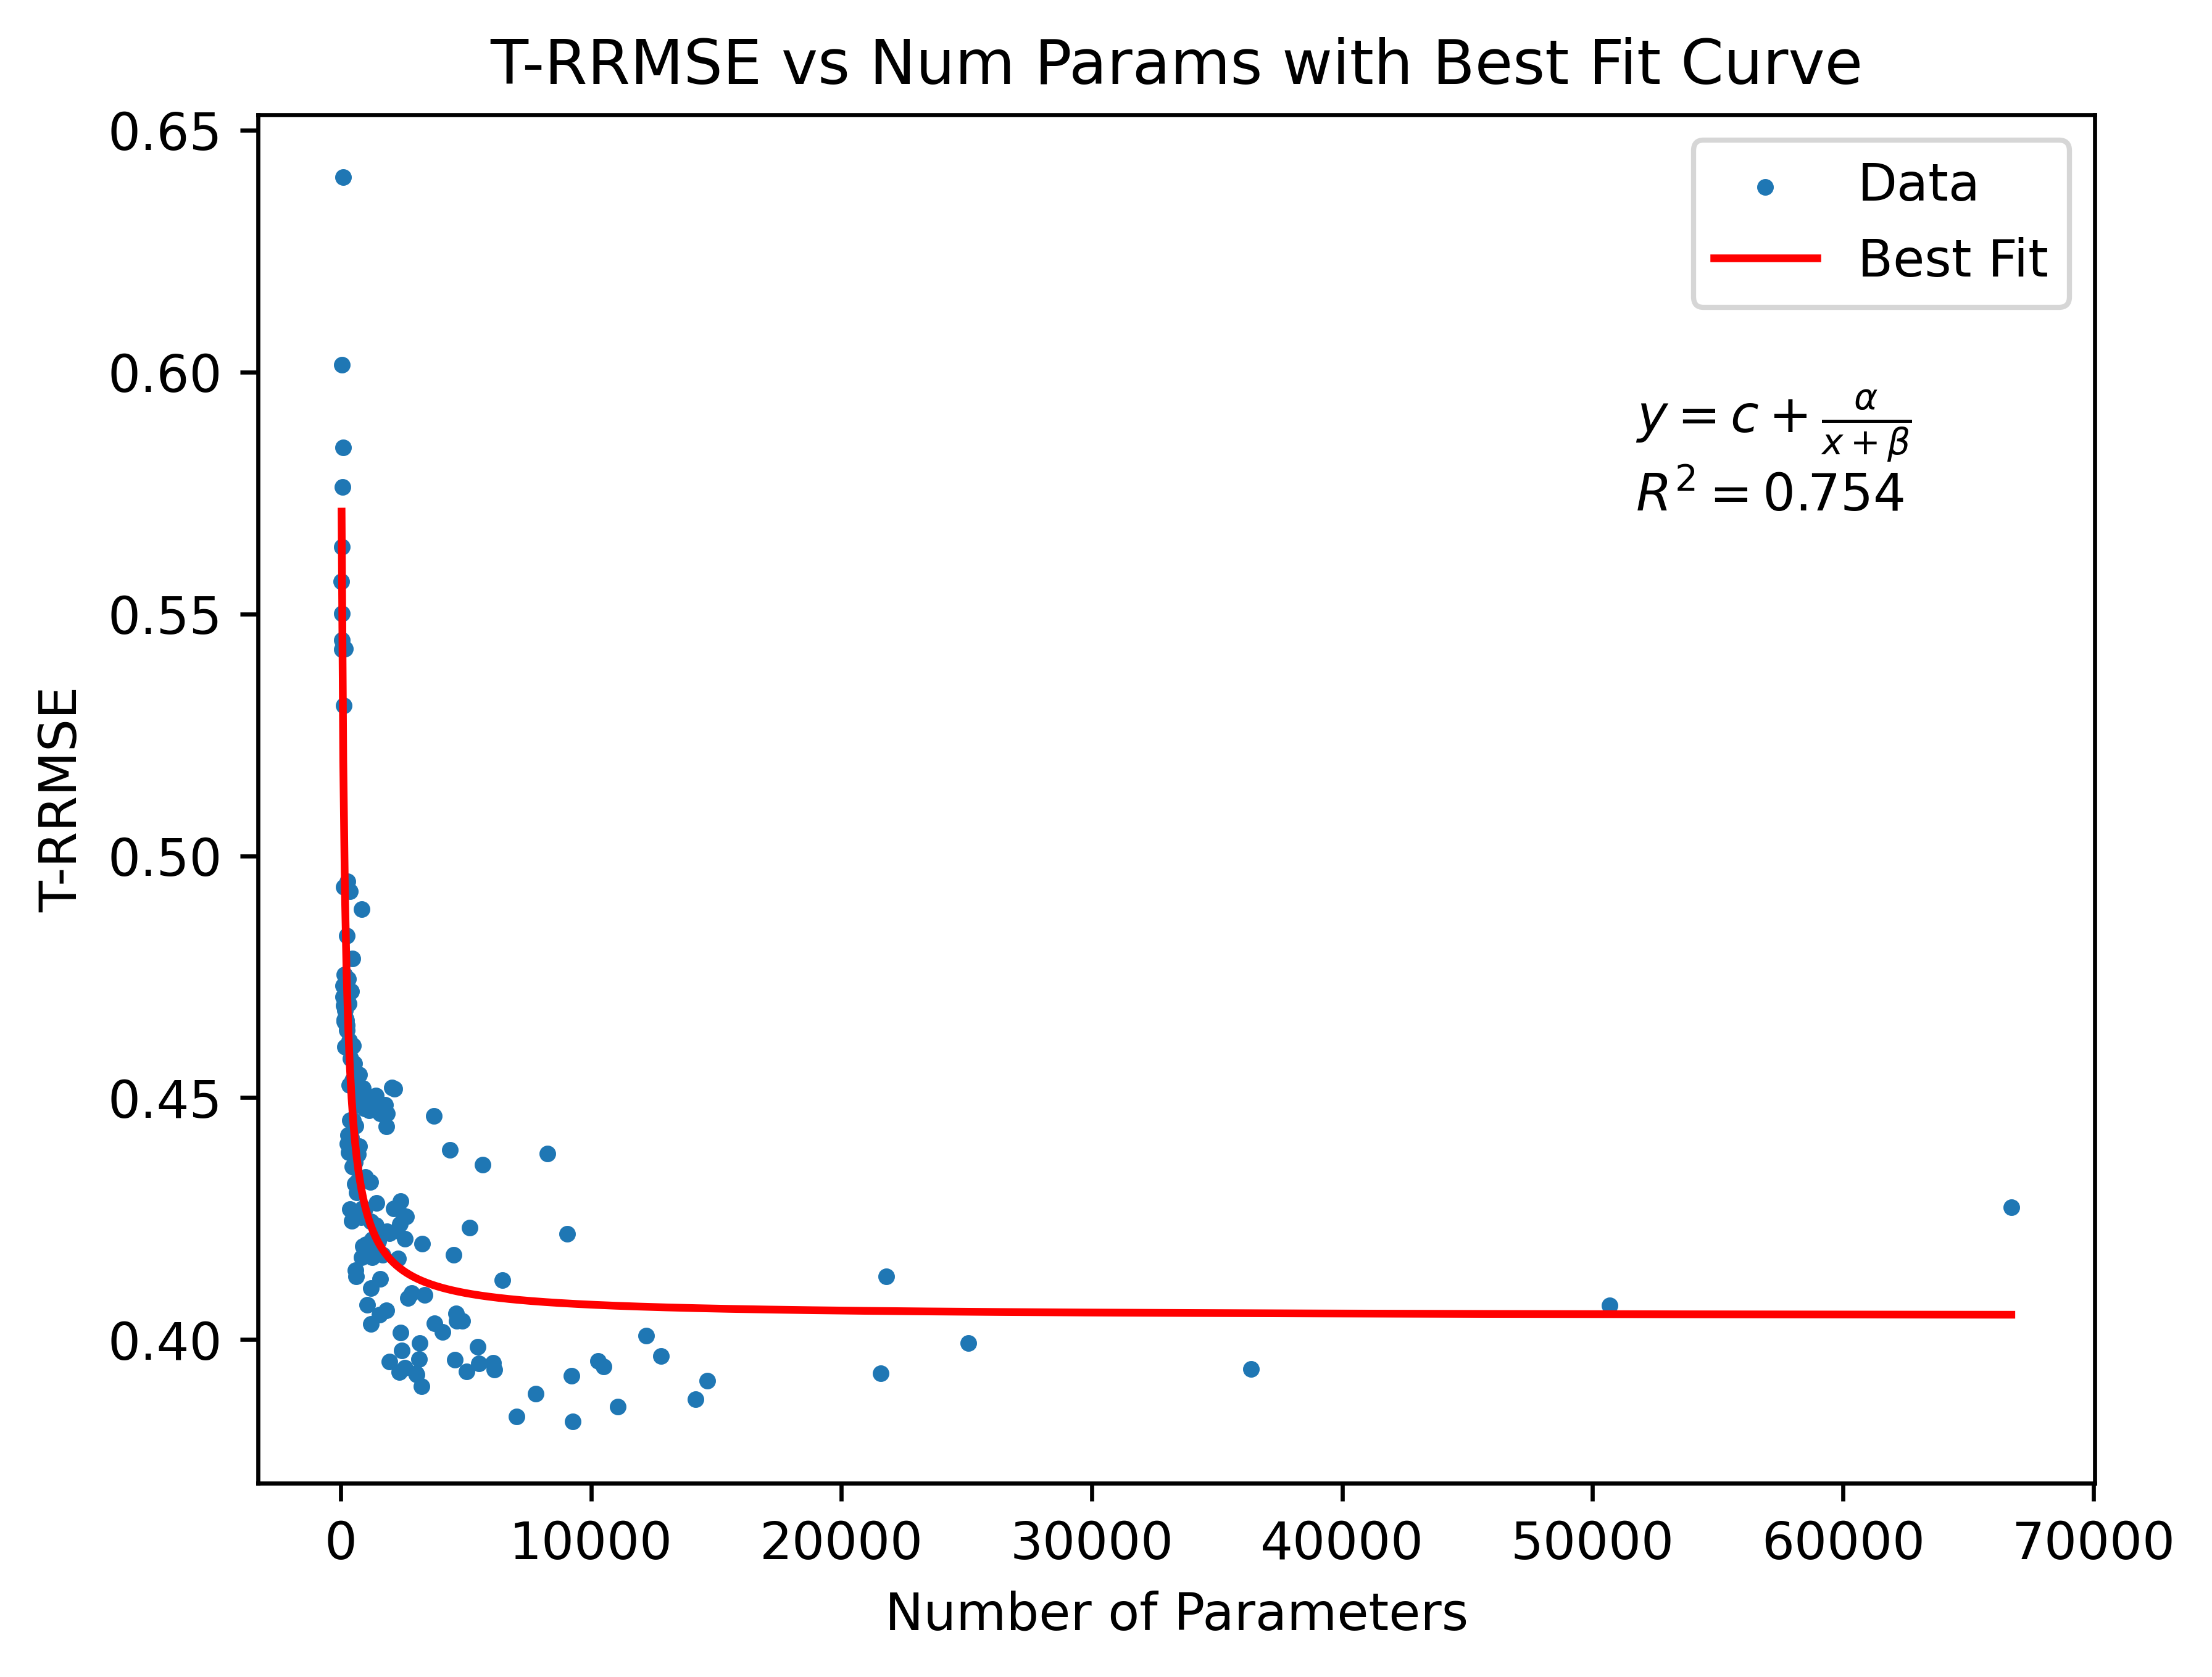

In [8]:
# plot the best fit
def plot_trend_lines(params, ys, results, best_name, name):
    x = params.astype(float).values
    y = ys
    # y = ys.astype(float).values
    x_fit = np.linspace(min(x), max(x), 1000)

    plt.figure(dpi=300)
    plt.scatter(x, y, s=5, label="Data")

    if best_name == "loglog":
        y_fit = loglog_model(x_fit, *results["loglog"][0])
    elif best_name == "log":
        y_fit = log_model(x_fit, *results["log"][0])
    elif best_name == "sigmoid":
        y_fit = sigmoid_model(x_fit, *results["sigmoid"][0])
    elif best_name == "1-exp":
        y_fit = exp_model(x_fit, *results["1-exp"][0])
    elif best_name == "1-exp-sqrt":
        y_fit = exp_sqrt_model(x_fit, *results["1-exp-sqrt"][0])
    elif best_name == "hyperbolic":
        y_fit = hyperbolic(x_fit, *results["hyperbolic"][0])
    

    # change this manually according to the plot

    plt.plot(x_fit, y_fit, color="red", label=f"Best Fit")
    # a * (1 - np.exp(-b * (x**p))) + c
    # plt.text(0.65, 0.25, r"$y = c + \alpha\left[1-\exp\left({\beta x^{-p}}\right)\right]$" +"\n"+"$R^2 = 0.726$", transform=plt.gca().transAxes, fontsize=10,
    #          verticalalignment='top')
    plt.text(0.75, 0.8, r"$y = c + \frac{\alpha}{x+\beta}$" + "\n" + r"$R^2 = 0.754$", transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top')
    plt.xlabel("Number of Parameters")
    plt.ylabel("T-RRMSE")
    plt.title(f"{name} with Best Fit Curve")
    plt.legend()
    plt.show()
    # c * np.log(np.log(x + b)) + d
    # c - a / (x + b)

results, best_name = fit_trend(params, rrmses)
plot_trend_lines(params, rrmses, results, best_name, "T-RRMSE vs Num Params")

Heatmaps to see how model types and sizes affect performance

In [9]:
# import seaborn as sns
# # make heatmaps? average of perf across 2 dimensions
# def heatmap(dim1, dim2, val):
#     # dim1 = df[dim1]
#     # dim2 = df[dim2]

#     g_df = df.groupby([dim1, dim2])[[val]].mean()
#     g_pivot = g_df.reset_index().pivot(index=dim1, columns=dim2, values=val)
#     # print(g_pivot)

#     pivot = g_pivot.to_numpy()

#     plt.figure(dpi=300)
#     sns.heatmap(pivot, annot=True, fmt=".3f", yticklabels=g_pivot.index, xticklabels=g_pivot.columns, cmap='crest')
#     plt.title(f"{val} across {dim1} × {dim2}")
#     plt.ylabel(dim1)
#     plt.xlabel(dim2)
#     plt.show()

#     # print(g_df_np_rrmse)

# dims = ['model_type', 'chans', 'groups', 'scale']
# metrics = ['rrmse', 'corr', 'sdr']

# for d1 in dims:
#     for d2 in dims:
#         if d1 != d2:
#             for m in metrics:
#                 print(f"Heatmap for {m} across {d1} and {d2}")
#                 heatmap(d1, d2, m)

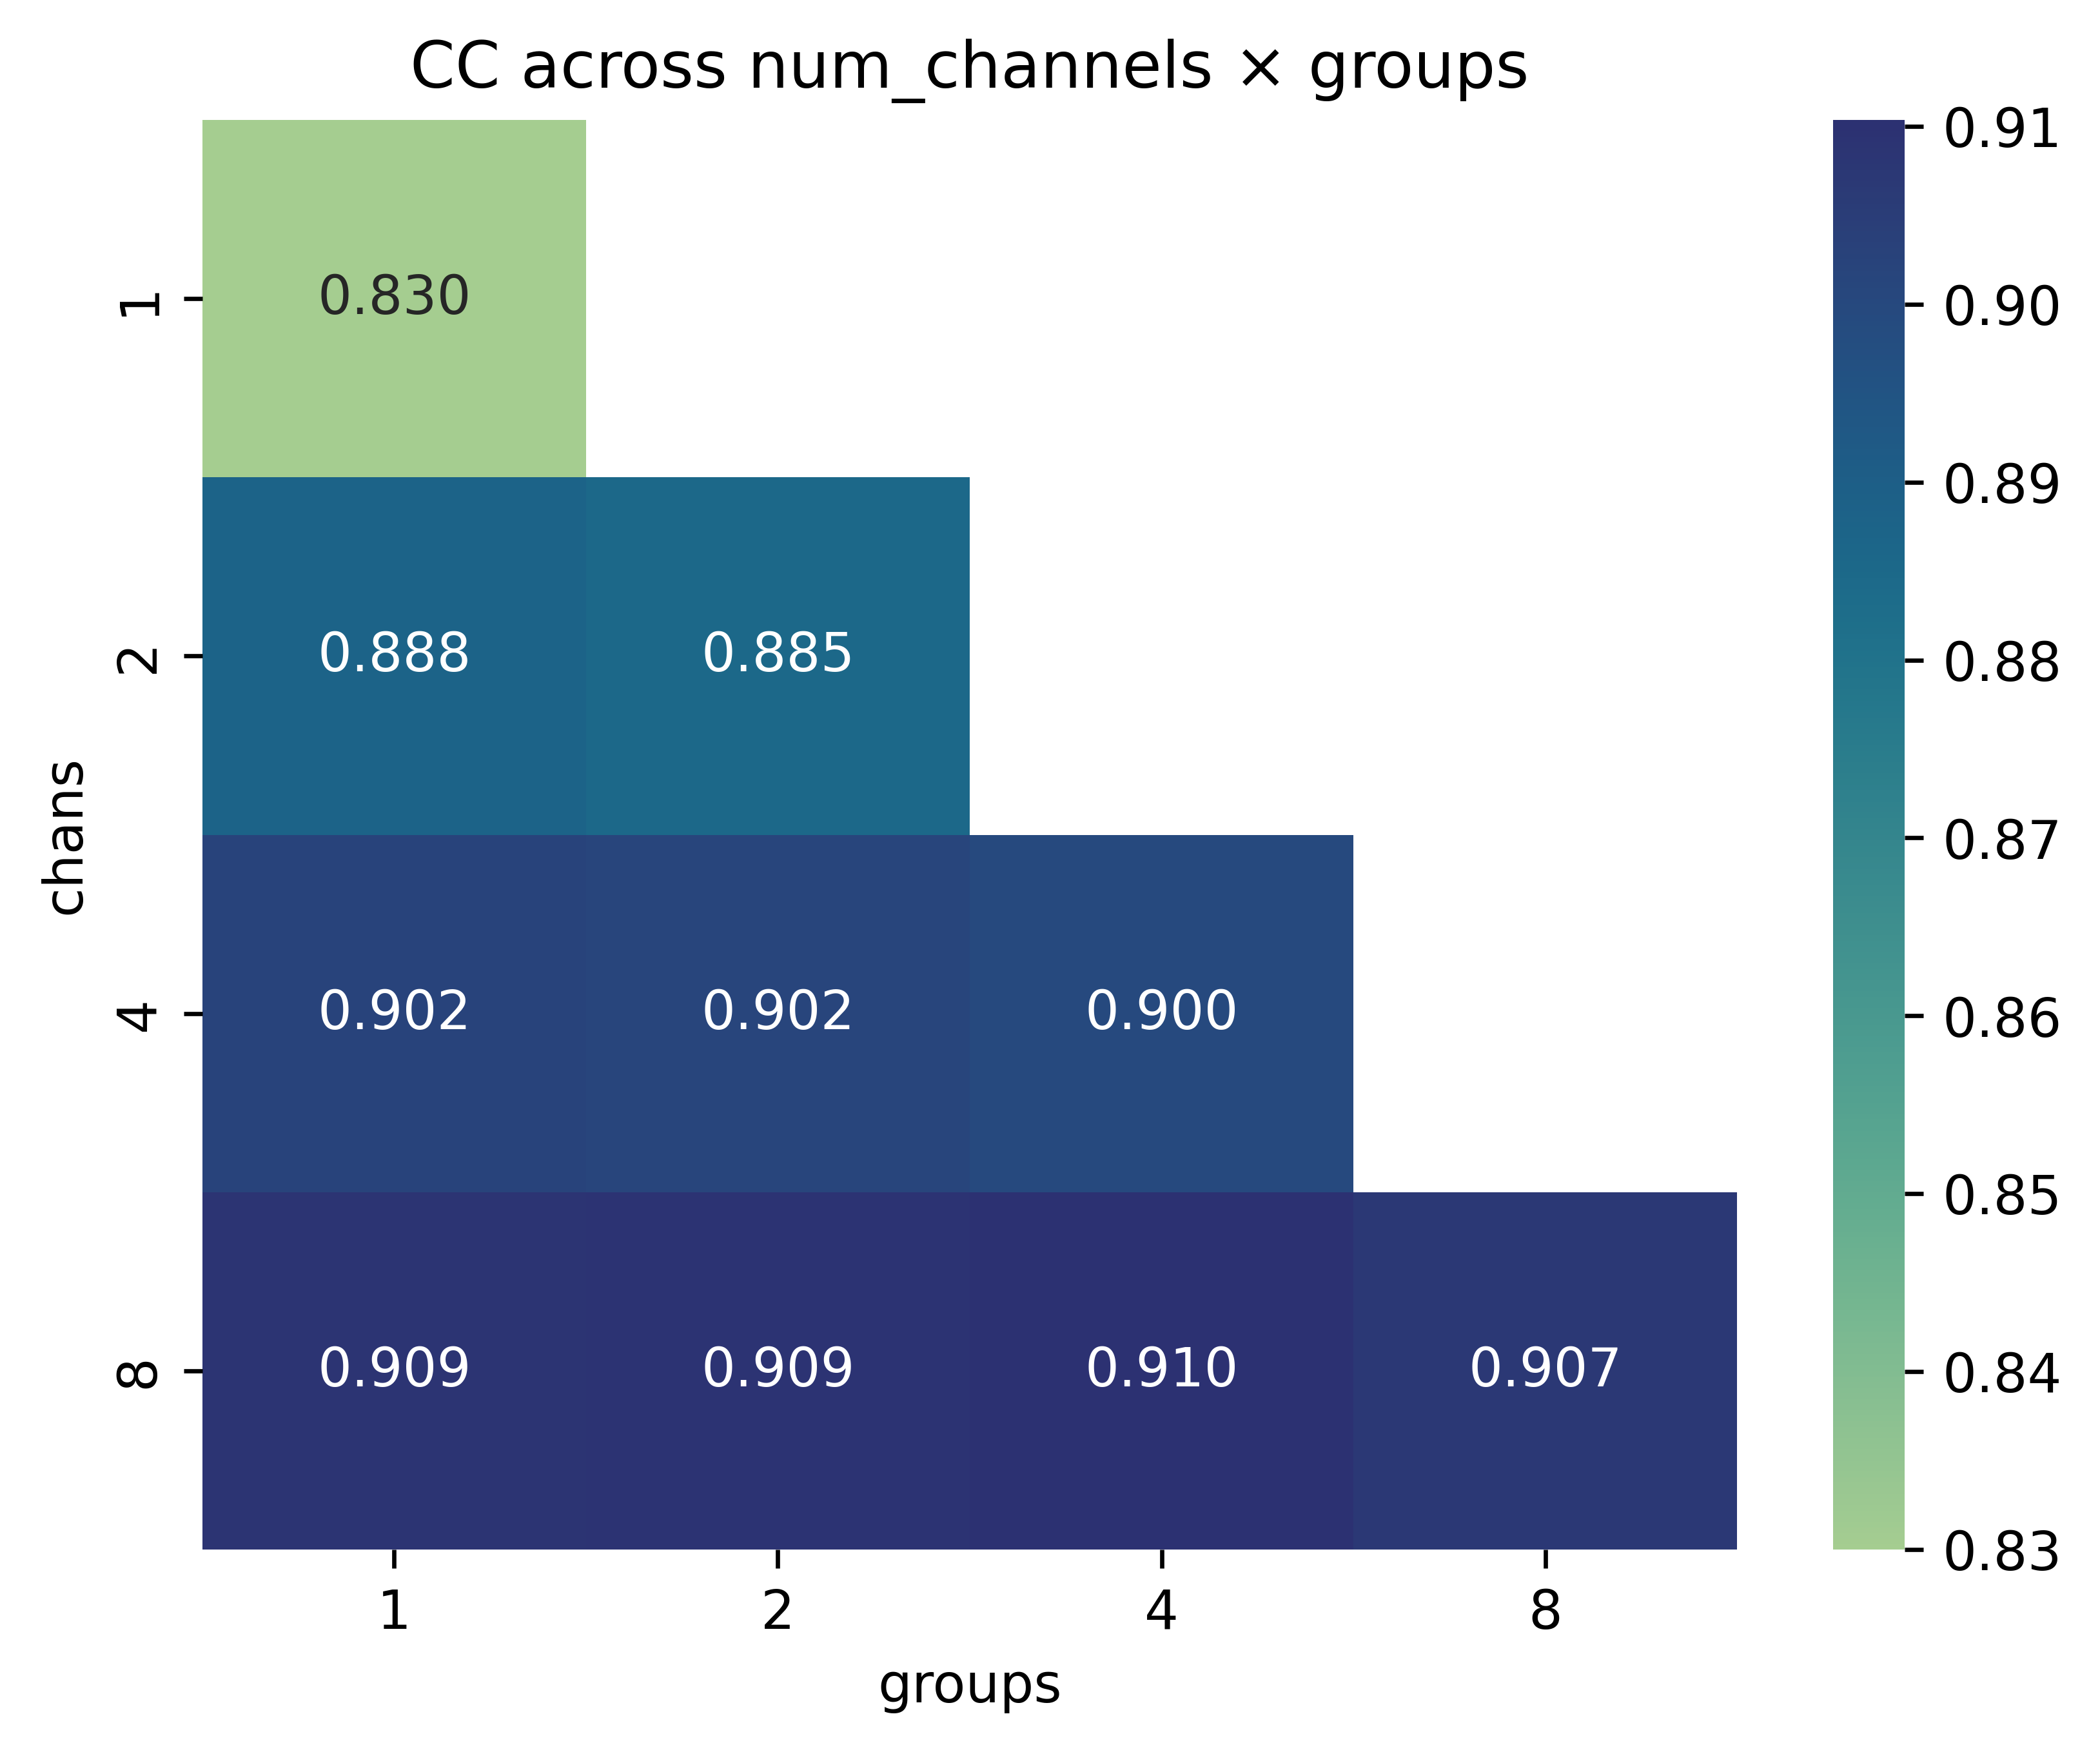

In [10]:
import seaborn as sns

dim2='groups'
dim1='chans'
val='corr'


g_df = df[df['chans'] < 16].groupby([dim1, dim2])[[val]].mean()
g_pivot = g_df.reset_index().pivot(index=dim1, columns=dim2, values=val)
# print(g_pivot)

pivot = g_pivot.to_numpy()

plt.figure(dpi=300)
sns.heatmap(pivot, annot=True, fmt=".3f", yticklabels=g_pivot.index, xticklabels=g_pivot.columns, cmap='crest')
plt.title(f"CC across num_channels × {dim2}")
plt.ylabel(dim1)
plt.xlabel(dim2)
plt.show()